In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import logging
import matplotlib.pyplot as plt
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import lightgbm as lgb
from sklearn.linear_model import Ridge
import joblib

import statsmodels.api as sm
import ta
from scipy.stats import spearmanr


import matplotlib.pyplot as plt
import warnings

from torch.utils.data import DataLoader, TensorDataset
import os
import random
from sklearn.preprocessing import StandardScaler


import lightgbm as lgb
import optuna
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from textwrap import wrap
from sklearn.model_selection import train_test_split

from scipy.stats import spearmanr

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


In [6]:
df=pd.read_csv('test_data.csv')
df

,dateId,secId,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,1,3,0.990836,2.365276,-1.156052,0.828425,-1.164050,-0.089868,0.214811,-0.731721,-0.002915,-2.220284
1,1,4,-0.379913,-0.056032,0.400995,0.016628,-1.388960,2.146695,-0.257895,-1.222817,0.010046,2.372056
2,1,5,-0.344393,-1.189023,0.377381,-0.430819,0.286977,-0.271771,-0.446971,-0.467624,0.005212,-0.181884
3,1,6,-0.386372,-1.549597,1.410493,-0.935795,-0.271669,-0.390210,-0.309768,-0.852401,0.004679,0.237587
4,1,9,-0.350852,1.263980,-0.720669,-0.754259,0.530024,-0.677077,-0.142927,-1.231398,-0.003127,-0.554313
...,...,...,...,...,...,...,...,...,...,...,...,...
191589,1257,414,-0.026435,-1.070948,2.087160,-0.803923,0.152038,-0.937418,-0.360214,0.510360,-0.002054,-0.444205
191590,1257,421,0.032107,-0.009719,1.837348,2.279017,0.284505,1.514191,-0.240182,0.021860,-0.000108,0.840285
191591,1257,422,NaN,-1.070948,1.434079,-0.704473,0.351557,-0.572574,-0.264284,1.807462,-0.005098,0.567491
191592,1257,424,-0.161078,-1.070948,-2.810950,0.177788,1.262476,0.867554,-0.385065,0.612129,-0.008825,-1.917713


In [7]:
"""data pre-process"""

'data pre-process'

In [8]:
#missing valus
print(df.isnull().sum())
print(df.isnull().sum() / len(df) * 100)

dateId        0
secId         0
X1        10747
X2            0
X3            0
X4            0
X5            0
X6         5890
X7         5747
X8            0
Y1            0
Y2            1
dtype: int64
dateId    0.000000
secId     0.000000
X1        5.609257
X2        0.000000
X3        0.000000
X4        0.000000
X5        0.000000
X6        3.074209
X7        2.999572
X8        0.000000
Y1        0.000000
Y2        0.000522
dtype: float64


In [9]:
#drop Y miss
df=df.dropna(subset=['Y2'])

In [10]:
#fill missing values
cols_to_fill = [f'X{i}' for i in range(1, 9)]
# group by secId and only forward fill (ffill)
df[cols_to_fill] = df.groupby('secId')[cols_to_fill].ffill()

In [ ]:
"""Design alpha factors"""

In [2]:

class Alpha_FactorEngineer:
    def __init__(self, df: pd.DataFrame):
        self.df = df
        self.df = self.df.sort_values(["secId", "dateId"])

    @staticmethod
    def zscore_by_group(df, group_col, target_col):
        return df.groupby(group_col)[target_col].transform(lambda x: (x - x.mean()) / x.std())
    
    @staticmethod
    def get_neutralized_factor_filled(df, group_col, target_col, by_col):
        """
        Calculate neutralization factors (residuals).
        Before each regression, fill NaN values ​​in Y and X with the median of the day.
        """
        residuals = []

        for _, group in df.groupby(group_col):
            Y = group[target_col].copy()
            X = group[by_col].copy()
            y_median = Y.median()
            x_median = X.median()
            Y.fillna(y_median, inplace=True)
            X.fillna(x_median, inplace=True)
            X = sm.add_constant(X, has_constant='add')

            if X.iloc[:, 1].std() < 1e-6:
                resid = Y - Y.mean()
            else:
                model = sm.OLS(Y, X).fit() 
                resid = model.resid

            residuals.append(resid)

        return pd.concat(residuals)

    @staticmethod
    def get_orthogonalized_factor(df, group_col, target_col, by_cols):
        """multivariate regression orthogonalization on the target factor and return the residual"""
        residuals = []
        if not isinstance(by_cols, list):
            by_cols = [by_cols]

        for _, group in df.groupby(group_col):
            Y = group[target_col]
            X = group[by_cols]
            X = sm.add_constant(X)

            model = sm.OLS(Y, X).fit()
            residuals.append(model.resid)

        return pd.concat(residuals)

    @staticmethod
    def bollinger_bandwidth(s, n=20, min_p=14, k=2):
        mid = s.rolling(n, min_periods=min_p).mean()
        std = s.rolling(n, min_periods=min_p).std()
        upper, lower = mid + k*std, mid - k*std
        return (upper - lower) / (mid + 1e-9)

    @staticmethod
    def calculate_pct_to_hi(series, window=30, min_p=15):
        hi_period = series.rolling(window, min_periods=min_p).max()
        return (series - hi_period) / hi_period
    
    @staticmethod
    def calculate_pct_to_lo(series, window=30, min_p=15):
        hi_period = series.rolling(window, min_periods=min_p).max()
        return (series - hi_period) / hi_period 
    
    @staticmethod
    def rsi_series(s, span=3):
        delta = s.diff()
        gain = delta.clip(lower=0)
        loss = -delta.clip(upper=0)
        rs = gain.ewm(span=span, adjust=False).mean() / (loss.ewm(span=span, adjust=False).mean() + 1e-9)
        return 100 - 100 / (1 + rs)
    
    @staticmethod
    def rolling_z(series, w=20, min_p=14):
        """Calculate rolling Z-score"""
        ma = series.rolling(w, min_periods=min_p).mean()
        sd = series.rolling(w, min_periods=min_p).std()
        return (series - ma) / (sd + 1e-9)
    
    @staticmethod
    def rolling_beta_alpha(sub, w=30, min_p=14):
        """rolling beta and alpha"""
        x = sub['ret_mkt']
        y = sub['Y1']
        rolling_cov = y.rolling(w, min_periods=min_p).cov(x)
        rolling_var = x.rolling(w, min_periods=min_p).var()
        # Beta
        beta = rolling_cov / (rolling_var + 1e-9)       
        # Alpha
        alpha = y.rolling(w, min_periods=min_p).mean() - beta * x.rolling(w, min_periods=min_p).mean()       
        return pd.DataFrame({'beta_30d': beta, 'alpha_30d': alpha}, index=sub.index)
    
    @staticmethod
    def top_n_corr_mean_optimized(row, num_top):
        valid_corrs = row.dropna()
        if len(valid_corrs) < num_top:
            return np.nan
        top_n_values = np.partition(valid_corrs, -num_top)[-num_top:]
        return np.mean(top_n_values)
    
    @staticmethod
    def calculate_daily_ic_for_t2(df, factor_col, fwd_ret_col='Y2_fwd2'):
        if fwd_ret_col not in df.columns:
            df[fwd_ret_col] = df.groupby('secId')['Y2'].shift(-2)       
        daily_ics = df.dropna(subset=[factor_col, fwd_ret_col]).groupby('dateId').apply(
            lambda x: spearmanr(x[factor_col], x[fwd_ret_col])[0]
        )
        return daily_ics
        
    def run_all(self):
        df = self.df
        df['X9'] = self.zscore_by_group(df, 'dateId', 'X4') + self.zscore_by_group(df, 'dateId', 'X3')
        df['X10'] = self.get_neutralized_factor_filled(df, 'dateId', 'X6', 'X2')
        df['X11'] = self.get_orthogonalized_factor(df, 'dateId', 'X3', ['X2', 'X8'])
        market_volatility = df.groupby('dateId')['Y1'].std()
        high_vol_regime = (market_volatility > market_volatility.rolling(window=40, min_periods=20).median().shift(1))
        df['X12'] = df['X8'] * df['dateId'].map(high_vol_regime).astype(int) 
        df['Y2_lag1'] = df.groupby('secId')['Y2'].shift(1)
        df['X13'] = df.groupby('dateId')['Y2_lag1'].transform(
            lambda x: (x - x.mean()) / x.std()
        ) * -1 
        df=df.drop(['Y2_lag1'],axis=1)
        df['quality_factor_stability'] = df.groupby('secId')['X3'].rolling(window=40, min_periods=12).std().shift(1).reset_index(0,drop=True)
        df['X14'] = df['quality_factor_stability'] * -1
        df=df.drop(['quality_factor_stability'],axis=1)
        df['X15'] = self.zscore_by_group(df, 'dateId', 'X4') * self.zscore_by_group(df, 'dateId', 'X6')

        df = df.sort_values(["secId", "dateId"])

        #define price
        df["px"] = df.groupby("secId")['Y1'].transform(
            lambda r: (1 + r).cumprod()
        )
        grp = df.groupby("secId", group_keys=False)

        #Momentum & Volatility
        print("Calculating momentum and volatility factors")
        for N in [3, 5]:
            df[f"ret_{N}d_m"] = grp["Y1"].transform(lambda s: s.rolling(N,min_periods=3).mean())
            df[f"px_{N}d_c"] = grp["px"].transform(lambda s: s / s.shift(N) - 1)
            df[f"ret_{N}d_std"] = grp["Y1"].transform(lambda s: s.rolling(N,min_periods=3).std()) #, min_periods=7
        N=10
        df[f"ret_{N}d_m"] = grp["Y1"].transform(lambda s: s.rolling(N,min_periods=7).mean())
        df[f"px_{N}d_c"] = grp["px"].transform(lambda s: s / s.shift(N) - 1)
        df[f"ret_{N}d_std"] = grp["Y1"].transform(lambda s: s.rolling(N,min_periods=7).std()) 

        N=20
        df[f"ret_{N}d_m"] = grp["Y1"].transform(lambda s: s.rolling(N,min_periods=14).mean())
        df[f"ret_{N}d_std"] = grp["Y1"].transform(lambda s: s.rolling(N,min_periods=14).std()) 

        df["px_3d_rel"] = grp["px"].transform(lambda s: s / s.rolling(3).mean())
        df["px_5d_rel"] = grp["px"].transform(lambda s: s / s.rolling(5,min_periods=4).mean())
        df["px_10d_rel"] = grp["px"].transform(lambda s: s / s.rolling(10,min_periods=7).mean())

        # ret skew & kurtosis
        df['ret_skew_20d'] = grp['Y1'].transform(lambda s: s.rolling(20,min_periods=14).skew())
        df['ret_kurt_20d'] = grp['Y1'].transform(lambda s: s.rolling(20,min_periods=14).kurt())

        # Technical Indicators
        grp = df.groupby("secId", group_keys=False)
        print("Calculating technical indicators RSI, WMA, BBands")

        # RSI 
        df["rsi_14"] = grp["px"].apply(lambda s: ta.momentum.rsi(s, window=14))
        df["rsi_3"] = grp["px"].apply(lambda s: ta.momentum.rsi(s, window=3))

        # WMA
        w_fast, w_slow = 5, 20
        df['wma_fast'] = grp['px'].apply(lambda s: s.ewm(span=w_fast, adjust=False).mean())
        df['wma_slow'] = grp['px'].apply(lambda s: s.ewm(span=w_slow, adjust=False).mean())
        df['ma_spread'] = df['wma_fast'] / df['wma_slow'] - 1  

        df['wma_3d'] = grp['px'].apply(lambda s: s.ewm(span=3, adjust=False).mean())
        df['wma_3d_std'] = grp['px'].apply(lambda s: s.ewm(span=3, adjust=False).std())
        df['wma_5d_std'] = grp['px'].apply(lambda s: s.ewm(span=5, adjust=False).std())

        # Bollinger Bandwidth
        df['bb_width_20d'] = grp['px'].apply(self.bollinger_bandwidth)

        # Price related
        grp = df.groupby("secId", group_keys=False)
        print("calculating price derivatives")
        df['px_chg1d'] = grp['px'].diff()

        df['pct_to_hi_30d'] = df.groupby('secId')['px'].transform(
            lambda s: self.calculate_pct_to_hi(s, window=30, min_p=15)
        )
        df['pct_to_hi_5d'] = df.groupby('secId')['px'].transform(
            lambda s: self.calculate_pct_to_hi(s, window=5, min_p=5)
        )
        df['pct_to_lo_30d'] = df.groupby('secId')['px'].transform(
            lambda s: self.calculate_pct_to_lo(s, window=30, min_p=15)
        )
        df['pct_to_lo_5d'] = df.groupby('secId')['px'].transform(
            lambda s: self.calculate_pct_to_lo(s, window=5, min_p=5)
        )

        #more advanced derivative factors
        df = df.sort_values(["secId", "dateId"])
        grp = df.groupby("secId", group_keys=False)
        
        print("Calculating more advanced derivative factors")

        # Another RSI
        df['RSI_custom'] = grp['px'].apply(self.rsi_series)
        df['RSI_custom_pct'] = grp['RSI_custom'].apply(lambda s: s.rolling(10,min_periods=7).rank(pct=True))
        # EMA
        df['EMA60'] = grp['px'].apply(lambda s: s.ewm(span=60, adjust=False).mean())
        # regression to see slope
        df['EMA60_slope'] = grp['EMA60'].apply(
            lambda s: s.rolling(5).apply(
                lambda x: np.polyfit(range(5), x, 1)[0] if not np.isnan(x).any() else np.nan,
                raw=True
            )
        )
        df['EMA60_slope_pct'] = grp['EMA60_slope'].apply(
            lambda s: s.rolling(7,min_periods=5).rank(pct=True)
        )
        df['EMA5'] = grp['px'].apply(lambda s: s.ewm(span=5, adjust=False).mean())
        df['EMA5_slope'] = grp['EMA5'].apply(
            lambda s: s.rolling(5).apply(
                lambda x: np.polyfit(range(5), x, 1)[0] if not np.isnan(x).any() else np.nan,
                raw=True
            )
        )
        df['EMA5_slope_pct'] = grp['EMA5_slope'].apply(
            lambda s: s.rolling(7,min_periods=5).rank(pct=True)
        )

        # px 
        df['rel_px'] = df['px'] / (df['EMA60'] + 1e-9)

        # free_float_mcap 
        df['log_mcap']=np.log(df['X2'])

        #turnover_z
        df = df.sort_values(["secId", "dateId"])
        grp = df.groupby("secId", group_keys=False)
        print("Calculating turnover_z using X6 as a proxy for turnover")
        df["turnover_z_from_X6"] = grp["X6"].transform(lambda s: self.rolling_z(s))


        # relative Beta Alpha compared to market
        print("Calculating market relative returns, Beta and Alpha")

        # Use the Y1 mean of all stocks on that day as the market return rate for that day
        df['ret_mkt'] = df.groupby('dateId')['Y1'].transform('mean')
        df["rel_ret_idx"] = df["Y1"] - df["ret_mkt"]
        df["rel_ret_ratio"] = (1 + df["Y1"]) / (1 + df["ret_mkt"]) - 1
        df = df.sort_values(['secId', 'dateId'])
        grp = df.groupby('secId', group_keys=False)
        beta_alpha_df = grp.apply(lambda sub: self.rolling_beta_alpha(sub))
        df = df.join(beta_alpha_df)


        # week day
        print("Calculating the weekly characteristics of the 1-7")
        df['dow'] = (df['dateId'] % 7) + 1
        for d in range(1, 8):
            df[f'dow_{d}'] = (df['dow'] == d).astype(int)

        df.drop(['dow'],axis=1)

        #cross-sectional rolling correlation factors
        df = df.sort_values(["secId", "dateId"])
        grp = df.groupby("secId", group_keys=False)
        print("constructing cross-sectional rolling correlation factors")
        rolling_windows = [5, 20]
        N_top_corr_list = [10, 50]
        ret_pivot = df.pivot(index='dateId', columns='secId', values='Y1')
        all_secs = ret_pivot.columns
        for window in rolling_windows:
            print(f"Start processing the rolling window period: {window} days")
            min_p = int(window * 0.7)
            results_for_window_df = pd.DataFrame(index=ret_pivot.index)
            
            for sec_id in all_secs:
                print(f"  secId: {sec_id} (Window: {window}days)")
                target_ret = ret_pivot[sec_id]
                other_rets = ret_pivot.drop(columns=[sec_id])
                # Calculate rolling correlation
                rolling_corrs = target_ret.rolling(window=window, min_periods=min_p).corr(other_rets)

                # Average correlation with the N most correlated stocks
                for N in N_top_corr_list:
                    mean_max_corr = rolling_corrs.apply(
                        lambda row: self.top_n_corr_mean_optimized(row, num_top=N), 
                        axis=1
                    )
                    results_for_window_df[f'{sec_id}_mean_max_corr_{window}d_N{N}'] = mean_max_corr

            factor_types_to_merge = []
            for N in N_top_corr_list:
                factor_types_to_merge.append(f'mean_max_corr_{window}d_N{N}')
                
            for factor_type in factor_types_to_merge:
                temp_wide_df = results_for_window_df.filter(like=f'_{factor_type}')
                temp_long_df = temp_wide_df.stack()
                temp_long_df.index.names = ['dateId', 'secId_str']
                temp_long_df.name = factor_type 
                temp_long_df = temp_long_df.reset_index()
                temp_long_df['secId'] = temp_long_df['secId_str'].str.replace(f'_{factor_type}', '').astype(int)
                df = df.merge(temp_long_df[['dateId', 'secId', factor_type]], on=['dateId', 'secId'], how='left')

        new_columns = [col for col in df.columns if 'mean_corr' in col]
        for col in new_columns:
            print(f"- {col}")

        df = df.sort_values(["secId", "dateId"])
        grp = df.groupby("secId", group_keys=False)
        print("Start constructing factor momentum alpha for all X factors")
        # Precompute the normalized version of the Z-score for all X factors
        factor_list = [f'X{i}' for i in range(1, 9)]
        for factor in factor_list:
            df[f'z_{factor}'] = df.groupby('dateId')[factor].transform(
                lambda x: (x - x.mean()) / x.std()
            )

        rolling_window = 20
        min_periods = 11
        for factor in factor_list:
            # Calculate the daily IC value of the factor
            daily_ic_series = self.calculate_daily_ic_for_t2(df, factor)
            # Calculate the rolling mean of IC and shift(2) to ensure no future function
            momentum_signal = daily_ic_series.rolling(
                window=rolling_window, min_periods=min_periods
            ).mean().shift(2)
            
            df[f'momentum_signal_{factor}'] = df['dateId'].map(momentum_signal) 
            # Construct the final Alpha factor (IC momentum weight * Z-score standardized factor)
            z_factor_col = f'z_{factor}'
            alpha_col_name = f'alpha_momentum_{factor}'
            df[alpha_col_name] = df[z_factor_col] * df[f'momentum_signal_{factor}']


        alpha_columns = [f'alpha_momentum_{factor}' for factor in factor_list]
        df=df.drop(['z_X1',	'z_X2',	'z_X3',	'z_X4',	'z_X5','z_X6','z_X7','z_X8','Y2_fwd2'],axis=1)


        print("constructing squared terms and relative intensity factors for X1-X8")
        feature_list = [f'X{i}' for i in range(1, 9)]

        for feature in feature_list:
            
            #square
            squared_col_name = f'{feature}_sq'
            df[squared_col_name] = df[feature] ** 2
            
            # Calculate relative strength (difference from the average of the day)
            relative_col_name = f'{feature}_rel_strength'
            daily_mean = df.groupby('dateId')[feature].transform('mean') 
            df[relative_col_name] = df[feature] - daily_mean
            
        new_columns = [col for col in df.columns if '_sq' in col or '_rel_strength' in col]

        grp = df.groupby("secId", group_keys=False)

        # Rolling Price Change
        for N in [3, 5]:
            df[f"ret_{N}d_m2"] = grp["Y2"].transform(lambda s: s.rolling(N,min_periods=3).mean())
            df[f"ret_{N}d_c2"] = grp["Y2"].transform(lambda s: s / s.rolling(N,min_periods=3).mean() - 1)
            df[f"ret_{N}d_std2"] = grp["Y2"].transform(lambda s: s.rolling(N,min_periods=3).std())
        N =10
        df[f"ret_{N}d_m2"] = grp["Y2"].transform(lambda s: s.rolling(N,min_periods=7).mean())
        df[f"ret_{N}d_c2"] = grp["Y2"].transform(lambda s: s / s.rolling(N,min_periods=7).mean() - 1)
        df[f"ret_{N}d_std2"] = grp["Y2"].transform(lambda s: s.rolling(N,min_periods=7).std())

        #target Y
        df = df.sort_values(["secId", "dateId"])
        df['target'] = df.groupby('secId')['Y2'].shift(-2) #day 1 predict day 3 ret

        self.df = df  # update class instance DataFrame
        return self.df


In [13]:
#process alpha factor
engineer = Alpha_FactorEngineer(df)
df_new = engineer.run_all()

Calculating momentum and volatility factors
Calculating technical indicators RSI, WMA, BBands
calculating price derivatives
Calculating more advanced derivative factors
Calculating turnover_z using X6 as a proxy for turnover
Calculating market relative returns, Beta and Alpha
Calculating the weekly characteristics of the 1-7
constructing cross-sectional rolling correlation factors
Start processing the rolling window period: 5 days
  secId: 1 (Window: 5days)
  secId: 2 (Window: 5days)
  secId: 3 (Window: 5days)
  secId: 4 (Window: 5days)
  secId: 5 (Window: 5days)
  secId: 6 (Window: 5days)
  secId: 7 (Window: 5days)
  secId: 8 (Window: 5days)
  secId: 9 (Window: 5days)
  secId: 10 (Window: 5days)
  secId: 11 (Window: 5days)
  secId: 12 (Window: 5days)
  secId: 13 (Window: 5days)
  secId: 14 (Window: 5days)
  secId: 15 (Window: 5days)
  secId: 16 (Window: 5days)
  secId: 17 (Window: 5days)
  secId: 18 (Window: 5days)
  secId: 19 (Window: 5days)
  secId: 20 (Window: 5days)
  secId: 21 (W

In [14]:
#target Y1
df=df_new.copy()
df = df.sort_values(["secId", "dateId"])
df['target1'] = df.groupby('secId')['Y1'].shift(-2)
df

,dateId,secId,X1,X2,X3,X4,X5,X6,X7,X8,...,ret_3d_c2,ret_3d_std2,ret_5d_m2,ret_5d_c2,ret_5d_std2,ret_10d_m2,ret_10d_c2,ret_10d_std2,target,target1
0,500,1,1.454097,0.193726,0.500152,-0.921745,-0.605759,NaN,-0.434589,-0.182274,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,356,2,-0.376183,-0.121047,0.174471,0.540169,-0.326991,2.593128,-0.480557,-0.824922,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.497769,0.000372
2,358,2,-0.399460,-0.138880,0.312082,0.497198,-0.047824,0.614543,-0.477067,-0.827563,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.011157,0.004521
3,359,2,-0.320153,-0.138880,0.343838,0.475113,-0.465584,1.072097,-0.476909,-0.838410,...,7.052612,1.169915,-0.185998,7.052612,1.169915,NaN,NaN,NaN,0.508056,-0.001222
4,360,2,-0.328173,-0.138880,0.397342,0.476225,-0.221859,-0.612248,-0.474993,-0.831494,...,2.992129,2.254467,0.613291,3.909835,1.862235,NaN,NaN,NaN,-0.333374,-0.001901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191588,544,448,0.404660,-0.794526,1.287348,-0.794393,2.002683,-0.281059,-0.402032,2.377009,...,1.809324,0.499502,-0.316530,-3.774080,1.144708,-0.193983,-5.526583,0.959743,-0.832711,-0.016909
191589,545,448,0.437686,-0.802876,1.440254,-0.805220,1.475239,-0.100889,-0.417100,2.437155,...,5.323092,1.218853,-0.561004,1.746242,1.268963,-0.385923,2.992126,1.022364,NaN,NaN
191590,546,448,0.343586,-0.805441,1.009556,-0.810529,1.973252,0.754310,-0.427299,2.460152,...,0.670676,1.243533,-0.287137,1.900048,0.928286,-0.490514,0.697629,1.007656,NaN,NaN
191591,500,449,1.454097,-1.157462,-0.775900,-0.840230,2.329083,NaN,-0.550980,1.161150,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
"""drop samples"""

In [15]:
#Find those secIds whose length is less than threshold 15, science using 15 days feature to construct alpha fctors
series_lengths = df.groupby('secId').size()
min_length = 15 
short_series_secs = series_lengths[series_lengths < min_length].index
print(f" {len(short_series_secs)} stocks is less than {min_length}") 
df_cleaned = df[~df['secId'].isin(short_series_secs)]
df_cleaned = df_cleaned.dropna(subset=['alpha_momentum_X6', 'target','rsi_14'])

 160 stocks is less than 15


In [ ]:

"""devide train / test, 8:2"""

In [ ]:


print("splitting the training and test sets by time, 80% vs 20%")

unique_dates = np.sort(df_cleaned['dateId'].unique())
n_days = len(unique_dates)
split_point_index = int(n_days * 0.8)
split_date = unique_dates[split_point_index - 1]

print(f"The date IDs for the partitions are {split_date} ")
train_df = df_cleaned[df_cleaned['dateId'] <= split_date]
test_df = df_cleaned[df_cleaned['dateId'] > split_date]
print(f"Train Set shape: {train_df.shape}")
print(f"Test Set shape: {test_df.shape}")


splitting the training and test sets by time, 80% vs 20%
The date IDs for the partitions are 1006 
Train Set shape: (149817, 121)
Test Set shape: (37183, 121)


In [ ]:
"""fill left missing data with train sec median, if all sec are non, fill with train median"""

In [18]:

def impute_features_with_train_medians_robust(train_df, test_df, feature_cols):
    train_df_filled = train_df.copy()
    test_df_filled = test_df.copy()

    stock_medians = train_df_filled.groupby('secId')[feature_cols].median()
    global_medians = train_df_filled[feature_cols].median()
    stock_medians.fillna(global_medians, inplace=True)

    for col in feature_cols:
        imputation_map = stock_medians[col]
        # First fill with the personalized median based on secId
        train_df_filled[col] = train_df_filled[col].fillna(train_df_filled['secId'].map(imputation_map))
        test_df_filled[col] = test_df_filled[col].fillna(test_df_filled['secId'].map(imputation_map))
        
        # Use global median as a final fallback, filling remaining NaNs
        global_median_for_col = global_medians[col]
        train_df_filled[col].fillna(global_median_for_col, inplace=True)
        test_df_filled[col].fillna(global_median_for_col, inplace=True)

    return train_df_filled, test_df_filled

all_feature_columns = [col for col in df_cleaned.columns if col not in ['dateId', 'secId', 'target','target1']] 

train_df_final, test_df_final = impute_features_with_train_medians_robust(
    train_df, 
    test_df, 
    all_feature_columns 
)

print("\n Number of NaNs in the training set:", train_df_final[all_feature_columns].isnull().sum().sum())
print("Number of NaNs in the testing set:", test_df_final[all_feature_columns].isnull().sum().sum())


 Number of NaNs in the training set: 0
Number of NaNs in the testing set: 0


In [ ]:
"""
Select features
Step1. Single factor IC ranking (training set),
Step 2. Remove highly correlated features
step 3. RFE
"""

In [ ]:


print("beginning the feature selection process")

train_df_final = train_df_final.sort_values('dateId')

# Step 1: select via single-factor IC 
# The correlation between all features and target
daily_ic_df = train_df_final.groupby('dateId').apply(
    lambda x: x[all_feature_columns].corrwith(x['target'], method='spearman')
)

mean_ic_series = daily_ic_df.mean()
ic_df = mean_ic_series.reset_index()
ic_df.columns = ['feature', 'mean_ic']
ic_df = ic_df.sort_values('mean_ic', key=abs, ascending=False).reset_index(drop=True)
print("Single factor IC ranking (training set):")
print(ic_df.head())

beginning the feature selection process
Single factor IC ranking (training set):
             feature   mean_ic
0                 X7 -0.011815
1    X7_rel_strength -0.011815
2              X7_sq  0.010737
3  alpha_momentum_X4 -0.008782
4              X6_sq  0.006036


In [20]:
#select feature with IC>0.002
print("\n Step1: remove low IC features on train set")
ic_threshold = 0.002
promising_features = ic_df.loc[ic_df['mean_ic'].abs() > ic_threshold, 'feature'].tolist()
print(f"\nIC value absolute value > {ic_threshold} features have {len(promising_features)} ")


 Step1: remove low IC features on train set

IC value absolute value > 0.002 features have 46 


In [ ]:
# Step 2: Remove highly correlated features,for each pair of highly correlated features, remove the one with the smaller IC value.
print("\n Step 2. Remove highly correlated features")
correlation_matrix = train_df_final[promising_features].corr().abs()
high_corr_pairs = []
corr_threshold = 0.98
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if correlation_matrix.iloc[i, j] > corr_threshold:
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))

features_to_remove = set()
for feat1, feat2 in high_corr_pairs:
    ic1 = ic_df.loc[ic_df['feature'] == feat1, 'mean_ic'].iloc[0]
    ic2 = ic_df.loc[ic_df['feature'] == feat2, 'mean_ic'].iloc[0]
    
    if abs(ic1) < abs(ic2):
        features_to_remove.add(feat1)
    else:
        features_to_remove.add(feat2)

final_features_step1 = [f for f in promising_features if f not in features_to_remove]
print(f"After remove high correlated, left {len(final_features_step1)} features")


 Step 2. Remove highly correlated features
After remove high correlated, left 36 features


In [ ]:
#step 3. RFE

train_part, valid_part = train_test_split(
    train_df_final, 
    test_size=0.3, 
    random_state=42,  
    shuffle=True
)

print(f"Original train dataset size: {len(train_df_final)}")
print(f"Training set size (70%): {len(train_part)}")
print(f"Valid set size (70%): {len(valid_part)}")


print("\n Step 3: Start Recursive Feature Elimination (RFE)")

params = {
    "objective": "regression_l1", 
    "metric": "l1",
    "learning_rate": 0.05,
    "num_leaves": 32,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "lambda_l2": 1,
    "seed": 42,
    "verbose": -1,
    "n_jobs": -1
}

def get_validation_ic_and_model(features, train_data, valid_data, model_params, target_col):
    lgb_train = lgb.Dataset(train_data[features], label=train_data[target_col])
    lgb_valid = lgb.Dataset(valid_data[features], label=valid_data[target_col])
    model = lgb.train(
        model_params,
        lgb_train,
        num_boost_round=300,  
        valid_sets=[lgb_valid],
        callbacks=[lgb.early_stopping(15, verbose=False)]
    )

    valid_data_copy = valid_data.copy()
    valid_data_copy['pred'] = model.predict(valid_data_copy[features], num_iteration=model.best_iteration)
    daily_ic = valid_data_copy.groupby('dateId').apply(lambda x: x['pred'].corr(x[target_col], method='spearman'))
    return daily_ic.mean(), model

current_features = final_features_step1.copy()
rfe_results = []
min_features_to_keep = 25

while len(current_features) > min_features_to_keep:
    val_ic, trained_model = get_validation_ic_and_model(current_features, train_part, valid_part, params, 'target')
    rfe_results.append({
        'num_features': len(current_features),
        'val_ic': val_ic,
        'features': current_features.copy()
    })
    print(f"Feature Num: {len(current_features):<3} | valid IC: {val_ic:.6f}")
    
    importance_df = pd.DataFrame({
        'feature': trained_model.feature_name(),
        'importance': trained_model.feature_importance(importance_type='gain')
    }).sort_values(
    by=['importance', 'feature'], 
    ascending=[True, True]
)

    # remove least importance feature
    feature_to_remove = importance_df.iloc[0]['feature']
    current_features.remove(feature_to_remove)


if not rfe_results:
    best_features_list = final_features_step1
else:
    best_run = max(rfe_results, key=lambda x: x['val_ic'])
    best_ic = best_run['val_ic']
    best_num = best_run['num_features']
    best_features_list = best_run['features']

    print(f"Best validation set Mean Daily IC: {best_ic:.6f}")
    print(f"The corresponding optimal number of features is: {best_num}")
    print("\n The best feature combinations are as follows:")
    print('\n'.join(wrap(str(best_features_list), 120)))

Original train dataset size: 149817
Training set size (70%): 104871
Valid set size (70%): 44946

 Step 3: Start Recursive Feature Elimination (RFE)
Feature Num: 36  | valid IC: 0.020481
Feature Num: 35  | valid IC: 0.017587
Feature Num: 34  | valid IC: 0.014679
Feature Num: 33  | valid IC: 0.018361
Feature Num: 32  | valid IC: 0.015471
Feature Num: 31  | valid IC: 0.018363
Feature Num: 30  | valid IC: 0.021222
Feature Num: 29  | valid IC: 0.012552
Feature Num: 28  | valid IC: 0.013655
Feature Num: 27  | valid IC: 0.010909
Feature Num: 26  | valid IC: 0.019258
Best validation set Mean Daily IC: 0.021222
The corresponding optimal number of features is: 30

 The best feature combinations are as follows:
['X7_rel_strength', 'X7_sq', 'alpha_momentum_X4', 'X6_sq', 'ret_10d_m2', 'alpha_momentum_X1', 'alpha_momentum_X7',
'turnover_z_from_X6', 'mean_max_corr_20d_N50', 'mean_max_corr_20d_N10', 'ret_10d_std2', 'X4', 'X1_sq', 'wma_3d_std',
'X13', 'X14', 'beta_30d', 'rel_px', 'X9', 'ret_10d_m', 'X5

In [ ]:
"""
Build model
Model1: LGBM
Model2:GRU
"""

In [ ]:
#LGBM with huber loss

In [23]:
train_part, valid_part = train_test_split(
    train_df_final, 
    test_size=0.18, 
    random_state=42,  # 使用一个固定的数字，比如 42，以保证结果可复现
    shuffle=True
)

# 查看划分后的大小，以确认操作正确
print(f"Original train dataset size: {len(train_df_final)}")
print(f"train size: {len(train_part)}")
print(f"valid size: {len(valid_part)}")

Original train dataset size: 149817
train size: 122849
valid size: 26968


In [ ]:
#use Optuna to select hyper-params (Huber Loss)

# Optuna's objective function
def objective(trial, train_data, valid_data, features, target_col):
    params = {
        "objective": "huber",       
        "metric": "huber",          
        "verbose": -1,
        "n_jobs": -1,
        "seed": 42,
        "alpha": trial.suggest_float("alpha", 0.8, 0.99), 
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "num_leaves": trial.suggest_int("num_leaves", 20, 100),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
    }

    lgb_train = lgb.Dataset(train_data[features], label=train_data[target_col])
    lgb_valid = lgb.Dataset(valid_data[features], label=valid_data[target_col])
    
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=1000,
        valid_sets=[lgb_valid],
        callbacks=[lgb.early_stopping(5, verbose=False)]
    )
    
    valid_data_copy = valid_data.copy()
    valid_data_copy['pred'] = model.predict(valid_data_copy[features], num_iteration=model.best_iteration)
    daily_ic = valid_data_copy.groupby('dateId').apply(lambda x: x['pred'].corr(x[target_col], method='spearman'))
    
    return daily_ic.mean()

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(lambda trial: objective(trial, train_part, valid_part, best_features_list, 'target'), n_trials=50)

best_params = study.best_params
print(" Hyperparameter optimization completed (Huber Loss)")
print(f"Best IC {study.best_value:.6f}")
print("The corresponding optimal hyperparameter combination:")
print(best_params)


# Train the final model using the optimal parameters
final_params = {
    "objective": "huber", 
    "metric": "huber",   
    "seed": 42,
    "verbose": -1,
    "n_jobs": -1,
}
final_params.update(best_params) 

# LGBM data
lgb_train_final = lgb.Dataset(train_df_final[best_features_list], label=train_df_final['target'])

#Determining the optimal number of iterations
print("Determining the optimal number of iterations")
model_for_best_iter = lgb.train(
    final_params,
    lgb.Dataset(train_part[best_features_list], label=train_part['target']),
    num_boost_round=2000,
    valid_sets=[lgb.Dataset(valid_part[best_features_list], label=valid_part['target'])],
    callbacks=[lgb.early_stopping(5, verbose=False)]
)
best_iteration = model_for_best_iter.best_iteration
print(f"The optimal number of iterations is determined to be: {best_iteration}")

# 训练最终模型
print("Training final model")
final_model_huber = lgb.train(
    final_params,
    lgb_train_final,
    num_boost_round=best_iteration
)
print("the model training is completed.")


[I 2025-06-29 22:26:24,038] A new study created in memory with name: no-name-697067aa-5a1b-44ec-b61a-8f3dc5f86af6
[I 2025-06-29 22:26:26,431] Trial 0 finished with value: 0.015775725272918335 and parameters: {'alpha': 0.8711626225809989, 'learning_rate': 0.09556428757689246, 'num_leaves': 79, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'lambda_l1': 3.3323645788192616e-08, 'lambda_l2': 0.6245760287469893}. Best is trial 0 with value: 0.015775725272918335.
[I 2025-06-29 22:26:28,718] Trial 1 finished with value: 0.02628789224368095 and parameters: {'alpha': 0.9142118522312097, 'learning_rate': 0.0737265320016441, 'num_leaves': 21, 'feature_fraction': 0.9879639408647978, 'bagging_fraction': 0.9329770563201687, 'bagging_freq': 3, 'lambda_l1': 4.329370014459266e-07, 'lambda_l2': 4.4734294104626844e-07}. Best is trial 1 with value: 0.02628789224368095.
[I 2025-06-29 22:26:31,218] Trial 2 finished with value: 0.021615283774009515 and para

 Hyperparameter optimization completed (Huber Loss)
Best IC 0.036543
The corresponding optimal hyperparameter combination:
{'alpha': 0.9622137162165975, 'learning_rate': 0.014206645210759112, 'num_leaves': 67, 'feature_fraction': 0.6949385448358855, 'bagging_fraction': 0.9718341818623628, 'bagging_freq': 7, 'lambda_l1': 0.004337553110767013, 'lambda_l2': 0.008346817030405468}
Determining the optimal number of iterations
The optimal number of iterations is determined to be: 115
Training final model
the model training is completed.


In [25]:

# Evaluate the final model on the test set
#
print("\n Evaluate the final model on the test set ")
predictions = final_model_huber.predict(test_df_final[best_features_list])
test_df_final['pred'] = predictions

# IC with Y2
mse = mean_squared_error(test_df_final['target'], test_df_final['pred'])
overall_ic = spearmanr(test_df_final['pred'].dropna(), test_df_final['target'].dropna())[0]
mean_daily_ic = test_df_final.groupby('dateId').apply(
    lambda x: x['pred'].corr(x['target'], method='spearman')
).mean()

print(f"MSE: {mse:.6f}")
print(f"Overall IC: {overall_ic:.6f}")
print(f"Mean Daily IC: {mean_daily_ic:.6f}")


 Evaluate the final model on the test set 
MSE: 0.989082
Overall IC: 0.020262
Mean Daily IC: 0.021049


In [26]:
#  IC with Y1
mse = mean_squared_error(test_df_final['target'], test_df_final['pred'])
overall_ic = spearmanr(test_df_final['pred'].dropna(), test_df_final['target1'].dropna())[0]
mean_daily_ic = test_df_final.groupby('dateId').apply(
    lambda x: x['pred'].corr(x['target1'], method='spearman')
).mean()


print(f"MSE: {mse:.6f}")
print(f"Overall IC: {overall_ic:.6f}")
print(f"Mean Daily IC: {mean_daily_ic:.6f}")

MSE: 0.989082
Overall IC: 0.027407
Mean Daily IC: 0.024117


In [3]:
# GRU with huber loss

print(" Start GRU time series prediction process")
def set_seed(seed_value=42):
    random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# GRU
class SimpleGRUModel(nn.Module):
    def __init__(self, num_features, hidden_size=64, num_layers=2, dropout=0.2):
        super(SimpleGRUModel, self).__init__()
        self.gru = nn.GRU(
            input_size=num_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.regressor = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        gru_out, _ = self.gru(x)
        predictions = self.regressor(gru_out[:, -1, :])
        return predictions

def create_sequences(df, feature_cols, target_col, sequence_length):
    X_list, y_list = [], []
    for _, group in df.groupby('secId'):
        if len(group) > sequence_length:
            feature_data = group[feature_cols].values
            target_data = group[target_col].values
            for i in range(len(group) - sequence_length):
                X_list.append(feature_data[i:i + sequence_length])
                y_list.append(target_data[i + sequence_length])
    return np.array(X_list, dtype=np.float32), np.array(y_list, dtype=np.float32).reshape(-1, 1)


 Start GRU time series prediction process


In [ ]:
SEED = 42
set_seed(SEED)
SEQUENCE_LENGTH = 30  
HIDDEN_SIZE = 64
NUM_LAYERS = 2
DROPOUT = 0.2
BATCH_SIZE = 256
LEARNING_RATE = 0.0001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {DEVICE}")


print("Normalizing features")
scaler = StandardScaler()
scaler.fit(train_part[best_features_list])
joblib.dump(scaler, 'scaler.joblib') 

train_part_scaled = train_part.copy()
valid_part_scaled = valid_part.copy()
test_df_final_scaled = test_df_final.copy()
train_part_scaled[best_features_list] = scaler.transform(train_part[best_features_list])
valid_part_scaled[best_features_list] = scaler.transform(valid_part[best_features_list])
test_df_final_scaled[best_features_list] = scaler.transform(test_df_final[best_features_list])
print("Feature standardization is complete.")

# Seq data
X_train, y_train = create_sequences(train_part_scaled, best_features_list, 'target', SEQUENCE_LENGTH)
X_valid, y_valid = create_sequences(valid_part_scaled, best_features_list, 'target', SEQUENCE_LENGTH)
X_test, y_test = create_sequences(test_df_final_scaled, best_features_list, 'target', SEQUENCE_LENGTH)

#PyTorch DataLoader
train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train)), batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid)), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test)), batch_size=BATCH_SIZE, shuffle=False)


# Initialize the model, loss function, and optimizer
gru_model = SimpleGRUModel(
    num_features=len(best_features_list),
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(DEVICE)

loss_fn = nn.HuberLoss(delta=1.0) # # Use Huber Loss
optimizer = torch.optim.AdamW(gru_model.parameters(), lr=LEARNING_RATE)


# Training and validation loop (with early stopping)
patience = 5
patience_counter = 0
best_valid_loss = float('inf')
epochs_limit = 100 

for epoch in range(epochs_limit):
    # train
    gru_model.train()
    total_train_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
        optimizer.zero_grad()
        predictions = gru_model(batch_X)
        loss = loss_fn(predictions, batch_y)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)

    # valid
    gru_model.eval()
    total_valid_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in valid_loader:
            batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
            predictions = gru_model(batch_X)
            loss = loss_fn(predictions, batch_y)
            total_valid_loss += loss.item()
    avg_valid_loss = total_valid_loss / len(valid_loader)
    
    print(f"Epoch {epoch+1}/{epochs_limit}, 训练Loss: {avg_train_loss:.6f}, 验证Loss: {avg_valid_loss:.6f}")
    
    # early stop
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        torch.save(gru_model.state_dict(), 'best_gru_model.pth')
        print(f"  Validation set loss improved, model saved to 'best_gru_model.pth'")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f" The validation set loss has not improved, Patience count: {patience_counter}/{patience}")

    if patience_counter >= patience:
        print(f"\n Early stopping triggered! Stop training at epoch {epoch+1}.")
        break

# load best model
gru_model.load_state_dict(torch.load('best_gru_model.pth'))

#evaluate
print("\n evaluate on test set")

gru_model.eval()
all_preds_gru = []
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(DEVICE)
        predictions = gru_model(batch_X)
        all_preds_gru.append(predictions.cpu().numpy())
test_predictions_gru = np.concatenate(all_preds_gru).flatten()

eval_df_rows = []
test_df_sorted = test_df_final.sort_values(['secId', 'dateId'])
for _, group in test_df_sorted.groupby('secId'):
    if len(group) > SEQUENCE_LENGTH:
        eval_df_rows.append(group.iloc[SEQUENCE_LENGTH:])
evaluation_df_gru = pd.concat(eval_df_rows)
evaluation_df_gru['pred_gru'] = test_predictions_gru

mse_gru = mean_squared_error(evaluation_df_gru['target'], evaluation_df_gru['pred_gru'])
overall_ic_gru = evaluation_df_gru[['pred_gru', 'target']].corr(method='spearman').iloc[0, 1]
mean_daily_ic_gru = evaluation_df_gru.groupby('dateId').apply(
    lambda x: x['pred_gru'].corr(x['target'], method='spearman')
).mean()


print(" Performance evaluation of the GRU model on the test set")
print(f"MSE: {mse_gru:.6f}")
print(f"Overall IC: {overall_ic_gru:.6f}")
print(f"Mean Daily IC: {mean_daily_ic_gru:.6f}")


 Start GRU time series prediction process
Device: cuda
Normalizing features
Feature standardization is complete.
Epoch 1/100, 训练Loss: 0.397520, 验证Loss: 0.399995
  Validation set loss improved, model saved to 'best_gru_model.pth'
Epoch 2/100, 训练Loss: 0.396531, 验证Loss: 0.399927
  Validation set loss improved, model saved to 'best_gru_model.pth'
Epoch 3/100, 训练Loss: 0.396866, 验证Loss: 0.399795
  Validation set loss improved, model saved to 'best_gru_model.pth'
Epoch 4/100, 训练Loss: 0.396468, 验证Loss: 0.399993
 The validation set loss has not improved, Patience count: 1/5
Epoch 5/100, 训练Loss: 0.396619, 验证Loss: 0.399970
 The validation set loss has not improved, Patience count: 2/5
Epoch 6/100, 训练Loss: 0.396270, 验证Loss: 0.399823
 The validation set loss has not improved, Patience count: 3/5
Epoch 7/100, 训练Loss: 0.396325, 验证Loss: 0.399803
 The validation set loss has not improved, Patience count: 4/5
Epoch 8/100, 训练Loss: 0.396436, 验证Loss: 0.399845
 The validation set loss has not improved, Pati

In [ ]:
"""Model Ensembling and Evaluation"""

In [ ]:
#Y2 as taregt
print(" Start model Ensembling and final evaluation, for target Y2")
ensemble_df = evaluation_df_gru.copy()
if 'pred' in test_df_final.columns:
    ensemble_df['pred_lgbm'] = test_df_final.loc[ensemble_df.index, 'pred']
else:
    raise ValueError("Can't find LGBM prediction column named 'pred' in 'test_df_final'!")

# weight
weight_lgbm = 0.7
weight_gru = 0.3
print(f"Ensemble: LightGBM={weight_lgbm}, GRU={weight_gru}")
ensemble_df['pred_ensemble'] = (
    weight_lgbm * ensemble_df['pred_lgbm'] +
    weight_gru * ensemble_df['pred_gru']
)

print("\n Evaluate the performance of the ensemble model")


overall_ic_df = ensemble_df[['pred_ensemble', 'target']].dropna()
ensemble_overall_ic, _ = spearmanr(overall_ic_df['pred_ensemble'], overall_ic_df['target'])
ensemble_mean_daily_ic = ensemble_df.groupby('dateId').apply(
    lambda x: x['pred_ensemble'].corr(x['target'], method='spearman')
).mean()


print("\n" + "="*50)
print(f" Ensemble (LGBM:{weight_lgbm}, LSTM:{weight_gru}) performance")
print(f"After Ensembel, Overall IC: {ensemble_overall_ic:.6f}")
print(f"After Ensembel,Mean Daily IC: {ensemble_mean_daily_ic:.6f}")

lgbm_ic_on_subset = ensemble_df.groupby('dateId').apply(
    lambda x: x['pred_lgbm'].corr(x['target'], method='spearman')
).mean()
gru_ic_on_subset = ensemble_df.groupby('dateId').apply(
    lambda x: x['pred_gru'].corr(x['target'], method='spearman')
).mean()

print("\n--- For comparison (on the same dataset): ---")
print(f"Only LGBM, Mean Daily IC: {lgbm_ic_on_subset:.6f}")
print(f"Only GRU, Mean Daily IC: {gru_ic_on_subset:.6f}")

 Start model Ensembling and final evaluation
Ensemble: LightGBM=0.7, GRU=0.3

 Evaluate the performance of the ensemble model

 Ensemble (LGBM:0.7, LSTM:0.3) performance
After Ensembel, Overall IC: 0.020474
After Ensembel,Mean Daily IC: 0.020647

--- For comparison (on the same dataset): ---
Only LGBM, Mean Daily IC: 0.015983
Only GRU, Mean Daily IC: 0.008431


In [29]:
#Y1 as taregt
print(" Start model Ensembling and final evaluation, for target Y1")


overall_ic_df = ensemble_df[['pred_ensemble', 'target1']].dropna()
ensemble_overall_ic, _ = spearmanr(overall_ic_df['pred_ensemble'], overall_ic_df['target1'])
ensemble_mean_daily_ic = ensemble_df.groupby('dateId').apply(
    lambda x: x['pred_ensemble'].corr(x['target1'], method='spearman')
).mean()

print(f"After Ensembel, Overall IC:  {ensemble_overall_ic:.6f}")
print(f"After Ensembel, Mean Daily IC: {ensemble_mean_daily_ic:.6f}")

lgbm_ic_on_subset = ensemble_df.groupby('dateId').apply(
    lambda x: x['pred_lgbm'].corr(x['target1'], method='spearman')
).mean()
gru_ic_on_subset = ensemble_df.groupby('dateId').apply(
    lambda x: x['pred_gru'].corr(x['target1'], method='spearman')
).mean()

print(f"Only LGBM, Mean Daily IC:  {lgbm_ic_on_subset:.6f}")
print(f"Only GRU, Mean Daily IC:  {gru_ic_on_subset:.6f}")

 Start model Ensembling and final evaluation, for target Y1
After Ensembel, Overall IC:  0.021917
After Ensembel, Mean Daily IC: 0.026224
Only LGBM, Mean Daily IC:  0.024196
Only GRU, Mean Daily IC:  0.011176


In [ ]:
"""Backtest"""

In [4]:

class PortfolioBacktester:
    def __init__(self, 
                 data_df: pd.DataFrame, 
                 signal_col: str, 
                 return_col: str, 
                 date_col: str = 'dateId', 
                 asset_col: str = 'secId'):
        
        self.raw_data = data_df.copy()
        self.signal_col = signal_col
        self.return_col = return_col
        self.date_col = date_col
        self.asset_col = asset_col
        self.backtest_df = None
        self.daily_metrics = None
        self.summary_stats = None

    def _prepare_data(self):

        df = self.raw_data.sort_values([self.asset_col, self.date_col])
        # The forecast signal generated on day T is shifted forward 2 days to serve as an actionable signal on day T+2.
        df['actionable_signal'] = df.groupby(self.asset_col)[self.signal_col].shift(2)
        self.backtest_df = df.dropna(subset=[self.return_col, 'actionable_signal'])
        
        if self.backtest_df.empty:
            raise ValueError("fail")

    def run(self, group_size: int = 20, commission_rate: float = 0.001):
        self._prepare_data()       
        print(f"Start daily backtesting, Portfolio size:: Top/Bottom {group_size}, cost_rate: {commission_rate}")
        date_ids = sorted(self.backtest_df[self.date_col].unique())
        prev_long = set()
        prev_short = set()
        daily_results = []

        for date_id in date_ids:
            daily_data = self.backtest_df[self.backtest_df[self.date_col] == date_id]
            if len(daily_data) < group_size * 2: continue

            daily_data = daily_data.sort_values(by='actionable_signal', ascending=False)
            current_long = set(daily_data.head(group_size)[self.asset_col])
            current_short = set(daily_data.tail(group_size)[self.asset_col])

            long_return = daily_data[daily_data[self.asset_col].isin(current_long)][self.return_col].mean()
            short_return = daily_data[daily_data[self.asset_col].isin(current_short)][self.return_col].mean()
            gross_pnl = long_return - short_return
            
            turnover = len(prev_long.symmetric_difference(current_long)) + len(prev_short.symmetric_difference(current_short))
            turnover_rate = turnover / (len(current_long) + len(current_short)) if (len(current_long) + len(current_short)) > 0 else 0
            commission = turnover_rate * commission_rate
            net_pnl = gross_pnl - commission
            
            daily_results.append({
                self.date_col: date_id, 'net_pnl': net_pnl, 'gross_pnl': gross_pnl, 'turnover_rate': turnover_rate
            })
            
            prev_long = current_long
            prev_short = current_short
            
        self.daily_metrics = pd.DataFrame(daily_results).set_index(self.date_col)
        self._calculate_summary_stats()
        return self

    def _calculate_summary_stats(self, annual_factor=243): # Trading days generally use 240-252, here we take the middle value
        if self.daily_metrics is None or self.daily_metrics.empty: return
        net_returns = self.daily_metrics['net_pnl']
        self.daily_metrics['equity_curve'] = (1 + net_returns).cumprod()
        total_return = self.daily_metrics['equity_curve'].iloc[-1] - 1
        annualized_return = net_returns.mean() * annual_factor
        annualized_volatility = net_returns.std() * np.sqrt(annual_factor)
        sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else 0
        cum_returns = self.daily_metrics['equity_curve']
        rolling_max = cum_returns.cummax()
        drawdown = (cum_returns - rolling_max) / rolling_max
        max_drawdown = drawdown.min()
        downside_returns = net_returns[net_returns < 0]
        downside_std = downside_returns.std() * np.sqrt(annual_factor) if not downside_returns.empty else 0
        sortino_ratio = annualized_return / downside_std if downside_std != 0 else 0
        calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else 0
        self.summary_stats = {
            'Total return': f"{total_return:.2%}", 'Annualized return': f"{annualized_return:.2%}",
            'Annualized Volatility': f"{annualized_volatility:.2%}", 'Annualized Sharp': f"{sharpe_ratio:.2f}",
            'Annualized Calmar': f"{calmar_ratio:.2f}",
            'Max DD': f"{max_drawdown:.2%}"#, '日均换手率': f"{self.daily_metrics['turnover_rate'].mean():.2%}"
        }
        
    def summary(self):
        if self.summary_stats is None: print("No summary information"); return
        print("Strategy Backtest Performance Summary")
        for key, value in self.summary_stats.items(): print(f"{key:<15}: {value}")

        
    def plot(self):
        if self.daily_metrics is None or self.daily_metrics.empty: print("no results to plot."); return
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
        self.daily_metrics['equity_curve'].plot(ax=ax1, linewidth=2, label='Strategy Cumulative NAV'); ax1.set_title('Strategy Cumulative Returns', fontsize=16); ax1.set_ylabel(' Cumulative NAV'); ax1.grid(True)
        drawdown = (self.daily_metrics['equity_curve'] - self.daily_metrics['equity_curve'].cummax()) / self.daily_metrics['equity_curve'].cummax()
        drawdown.plot(ax=ax2, kind='area', color='red', alpha=0.3, label='Drawdown'); ax2.set_title('Strategy Drawdown Curve', fontsize=12); ax2.set_xlabel('Date (dateId)'); ax2.set_ylabel(' Drawdown'); ax2.grid(True)
        plt.tight_layout(); plt.show()

Backtesting Ensemble model strategy (LGBM + GRU)
Start daily backtesting, Portfolio size:: Top/Bottom 20, cost_rate: 0.0001
Strategy Backtest Performance Summary
Total return   : 11.18%
Annualized return: 11.93%
Annualized Volatility: 3.26%
Annualized Sharp: 3.66
Annualized Calmar: 9.74
Max DD         : -1.22%


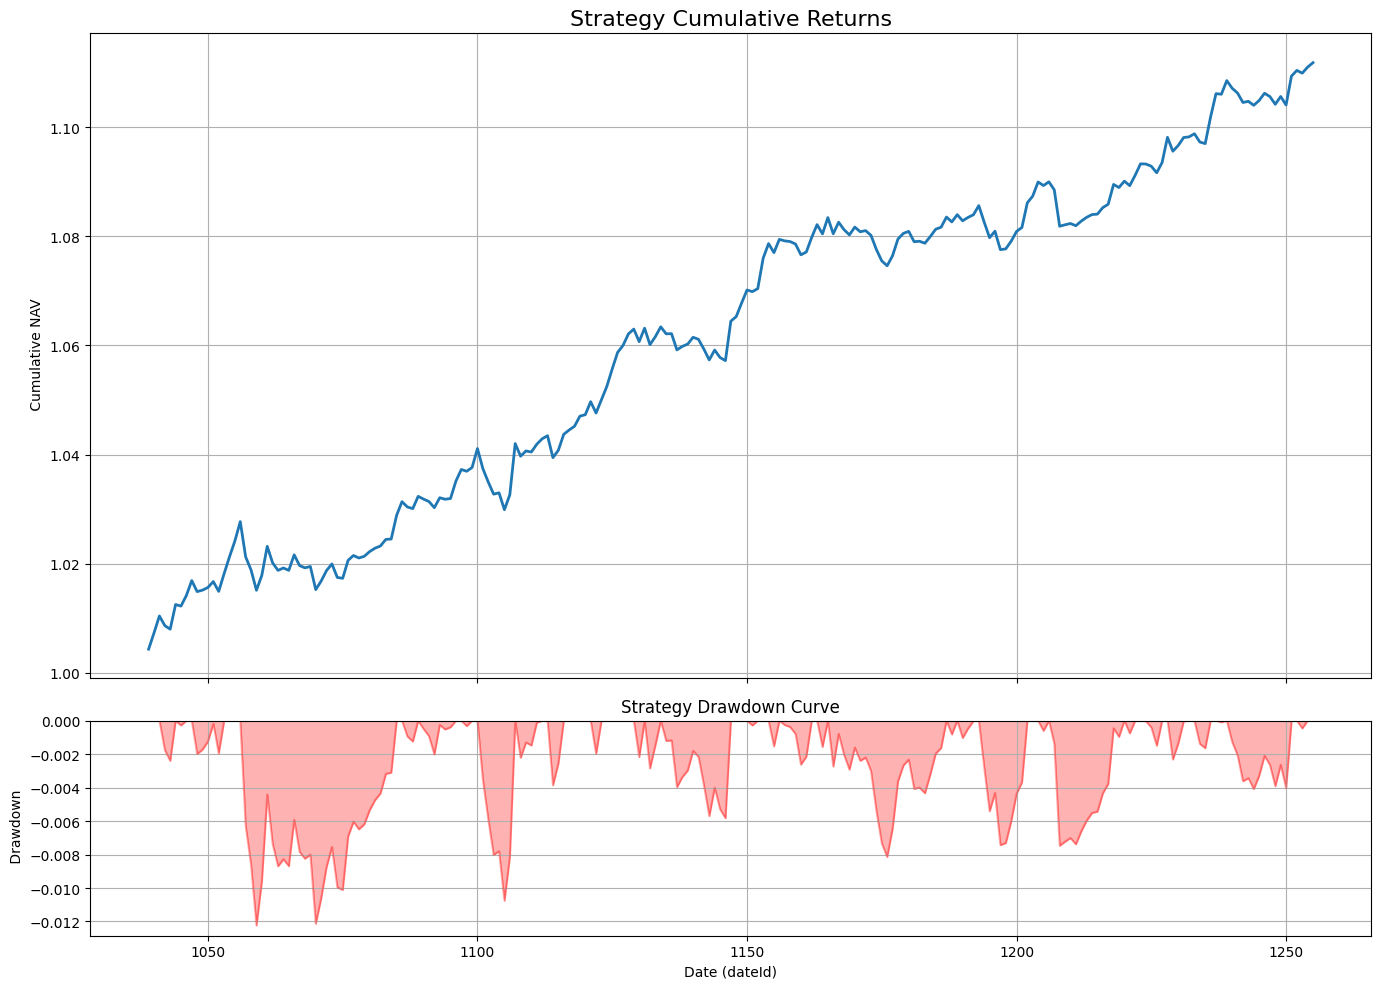

Backtesting the single LightGBM model
Start daily backtesting, Portfolio size:: Top/Bottom 20, cost_rate: 0.0001
Strategy Backtest Performance Summary
Total return   : 8.71%
Annualized return: 8.29%
Annualized Volatility: 3.86%
Annualized Sharp: 2.15
Annualized Calmar: 4.83
Max DD         : -1.72%


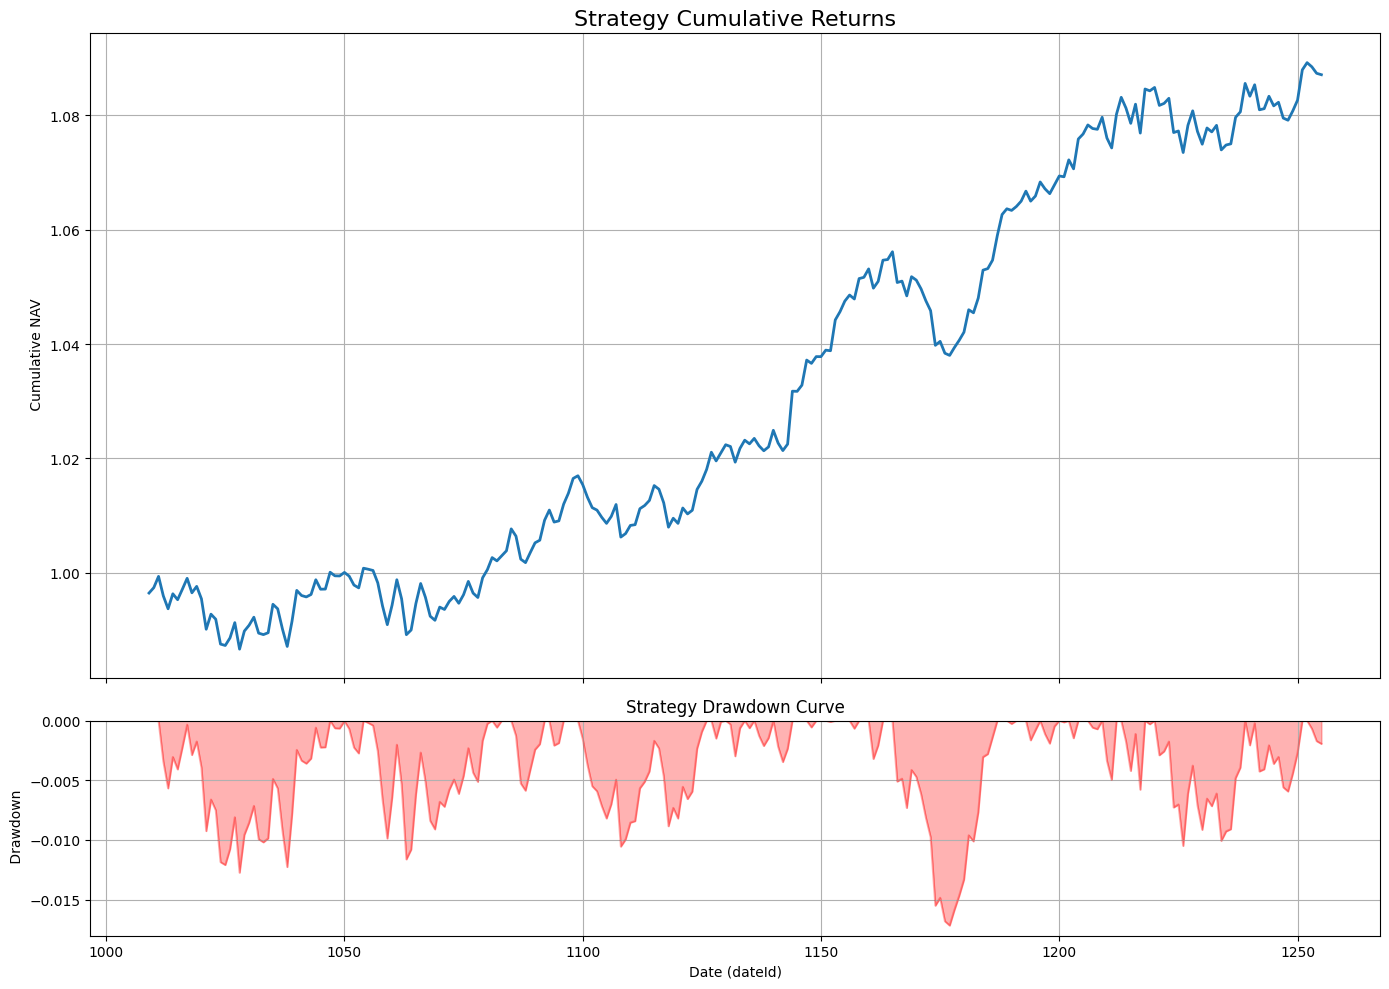

In [31]:
#main
GROUP_SIZE = 20  #Top 20 vs Bottom 20
COMMISSION_RATE = 0.0001# 10bps

print("Backtesting Ensemble model strategy (LGBM + GRU)")
backtest_data_ensemble = ensemble_df.copy()
if 'Y1' not in backtest_data_ensemble.columns:
    backtest_data_ensemble = backtest_data_ensemble.merge(
        test_df_final[['dateId', 'secId', 'Y1']],
        on=['dateId', 'secId'],
        how='left'
    )

backtester_ensemble = PortfolioBacktester(
    data_df=backtest_data_ensemble,
    signal_col='pred_ensemble', 
    return_col='Y1'  #use Y1 as true ret
)
backtester_ensemble.run(group_size=GROUP_SIZE, commission_rate=COMMISSION_RATE)
backtester_ensemble.summary()
backtester_ensemble.plot()


print("Backtesting the single LightGBM model")
backtest_data_lgbm = test_df_final.copy()

backtester_lgbm = PortfolioBacktester(
    data_df=backtest_data_lgbm,
    signal_col='pred',
    return_col='Y1'
)
backtester_lgbm.run(group_size=GROUP_SIZE, commission_rate=COMMISSION_RATE)
backtester_lgbm.summary()
backtester_lgbm.plot()

In [ ]:
import joblib
final_model_huber.save_model('lgbm_model.txt')
joblib.dump(scaler, 'scaler.joblib')

with open('best_features_list.txt', 'w') as f:
    for feature in best_features_list:
        f.write(f"{feature}\n")

In [47]:
########finish

In [ ]:
"""
test on out-of sample data:
here is an example, use last 20% of test.csv as out-of sample, when test on true out-of-sample data,
change df_outsample to new dataset which has same form of test.csv

Before run following, remember to run:
class Alpha_FactorEngineer
class PortfolioBacktester
class SimpleGRUModel(nn.Module)
def create_sequences
"""

In [5]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import joblib
import random
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [7]:
df_all=pd.read_csv('test_data.csv')
unique_dates = np.sort(df_all['dateId'].unique())
n_days = len(unique_dates)
split_point_index = int(n_days * 0.8)
split_date = unique_dates[split_point_index - 1]

print(f"The date IDs for the partitions are {split_date} ")
df_insample= df_all[df_all['dateId'] <= split_date]
df_outsample = df_all[df_all['dateId'] > split_date] #change df_outsample to new dataset which has same form of test.csv
print(f"Test Set shape: {df_outsample.shape}")

The date IDs for the partitions are 1005 
Test Set shape: (37800, 12)


In [9]:


def set_seed(seed_value=42):
    random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


SEED = 42
set_seed(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

#load:
# best_features_list
with open('best_features_list.txt', 'r') as f:
    best_features_list = [line.strip() for line in f.readlines()]
# scaler
scaler = joblib.load('scaler.joblib')
# lgbm
lgbm_model = lgb.Booster(model_file='lgbm_model.txt')
# GRU
SEQUENCE_LENGTH = 30 
gru_model = SimpleGRUModel(num_features=len(best_features_list)).to(DEVICE)
gru_model.load_state_dict(torch.load('best_gru_model.pth'))
gru_model.eval() 
print("All models and tools loaded.")


#data
oos_df = df_outsample 

# pre process(same as train)
oos_df = oos_df.dropna(subset=['Y2'])
cols_to_fill = [f'X{i}' for i in range(1, 9)]
oos_df[cols_to_fill] = oos_df.groupby('secId')[cols_to_fill].ffill()

# get alpah
engineer = Alpha_FactorEngineer(oos_df)
oos_df_new = engineer.run_all()

# Target 
oos_df_new = oos_df_new.sort_values(["secId", "dateId"])
oos_df_new['target1'] = oos_df_new.groupby('secId')['Y1'].shift(-2)

# clean
series_lengths = oos_df_new.groupby('secId').size()
min_length = 15
short_series_secs = series_lengths[series_lengths < min_length].index
oos_df_cleaned = oos_df_new[~oos_df_new['secId'].isin(short_series_secs)]
oos_df_cleaned = oos_df_cleaned.dropna(subset=['alpha_momentum_X6', 'target','rsi_14'])

#fill
for feature in best_features_list:
    if oos_df_cleaned[feature].isnull().any():
        group_medians = oos_df_cleaned.groupby('secId')[feature].transform('median')
        global_median = oos_df_cleaned[feature].median()        
        oos_df_cleaned[feature].fillna(group_medians, inplace=True)       
        oos_df_cleaned[feature].fillna(global_median, inplace=True)

#model
# LGBM
print("LGBM is predicting")
lgbm_preds = lgbm_model.predict(oos_df_cleaned[best_features_list])
oos_df_cleaned['pred_lgbm'] = lgbm_preds

# GRU
print("GRU is predicting")
oos_df_scaled = oos_df_cleaned.copy()
oos_df_scaled[best_features_list] = scaler.transform(oos_df_scaled[best_features_list])
X_oos, y_oos = create_sequences(oos_df_scaled, best_features_list, 'target', SEQUENCE_LENGTH)
oos_loader = DataLoader(TensorDataset(torch.from_numpy(X_oos)), batch_size=256, shuffle=False)

all_preds_gru = []
with torch.no_grad():
    for batch_X in oos_loader:
        batch_X = batch_X[0].to(DEVICE)
        predictions = gru_model(batch_X)
        all_preds_gru.append(predictions.cpu().numpy())
gru_preds = np.concatenate(all_preds_gru).flatten()

# Ensemble
print("Aligning LGBM and GRU predictions")
eval_df_rows = []
oos_df_sorted = oos_df_cleaned.sort_values(['secId', 'dateId'])
for _, group in oos_df_sorted.groupby('secId'):
    if len(group) > SEQUENCE_LENGTH:
        eval_df_rows.append(group.iloc[SEQUENCE_LENGTH:])
ensemble_df_oos = pd.concat(eval_df_rows)
ensemble_df_oos['pred_gru'] = gru_preds
ensemble_df_oos['pred_lgbm'] = oos_df_cleaned.loc[ensemble_df_oos.index, 'pred_lgbm']




All models and tools loaded.
Calculating momentum and volatility factors
Calculating technical indicators RSI, WMA, BBands
calculating price derivatives
Calculating more advanced derivative factors
Calculating turnover_z using X6 as a proxy for turnover
Calculating market relative returns, Beta and Alpha
Calculating the weekly characteristics of the 1-7
constructing cross-sectional rolling correlation factors
Start processing the rolling window period: 5 days
  secId: 3 (Window: 5days)
  secId: 4 (Window: 5days)
  secId: 6 (Window: 5days)
  secId: 7 (Window: 5days)
  secId: 8 (Window: 5days)
  secId: 9 (Window: 5days)
  secId: 11 (Window: 5days)
  secId: 14 (Window: 5days)
  secId: 17 (Window: 5days)
  secId: 18 (Window: 5days)
  secId: 20 (Window: 5days)
  secId: 21 (Window: 5days)
  secId: 22 (Window: 5days)
  secId: 26 (Window: 5days)
  secId: 27 (Window: 5days)
  secId: 37 (Window: 5days)
  secId: 38 (Window: 5days)
  secId: 40 (Window: 5days)
  secId: 44 (Window: 5days)
  secId: 4


IC evaluation of fusion model for Target Y2 (Y2.shift(-2)):
Overall IC: 0.020041, Mean Daily IC: 0.019898

IC evaluation of the fusion model for Target Y1 (Y1.shift(-2)):
Overall IC: 0.017632, Mean Daily IC: 0.024386

 Backtest
Start daily backtesting, Portfolio size:: Top/Bottom 20, cost_rate: 0.0001
Strategy Backtest Performance Summary
Total return   : 9.26%
Annualized return: 10.55%
Annualized Volatility: 3.14%
Annualized Sharp: 3.37
Annualized Calmar: 9.57
Max DD         : -1.10%


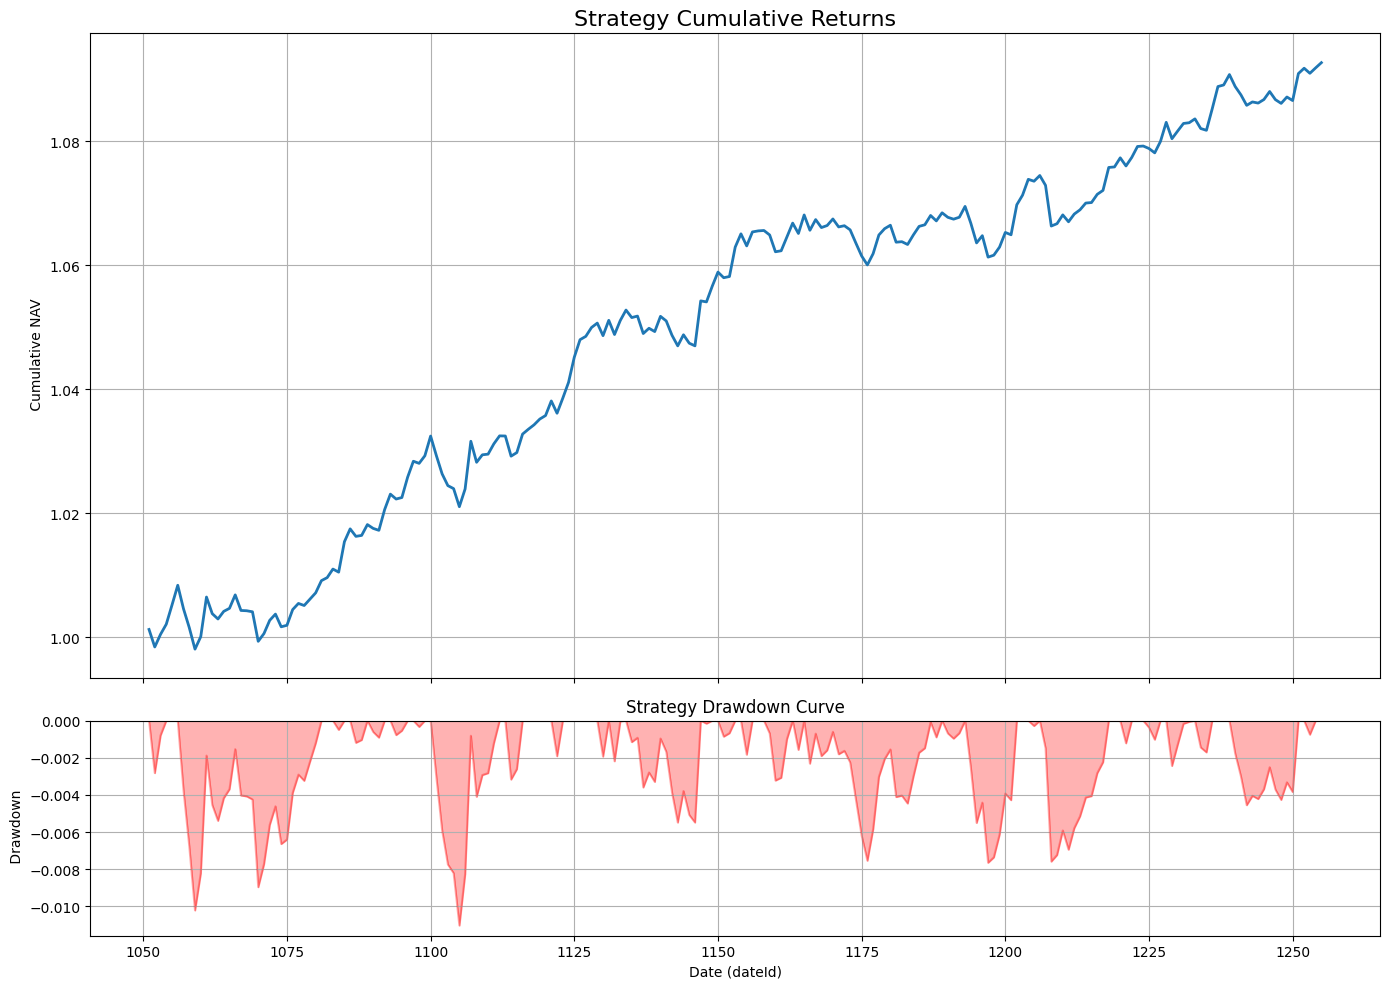

In [ ]:
# Evaluate
weight_lgbm, weight_gru = 0.7, 0.3
ensemble_df_oos['pred_ensemble'] = weight_lgbm * ensemble_df_oos['pred_lgbm'] + weight_gru * ensemble_df_oos['pred_gru']

print(f"\nIC evaluation of fusion model for Target Y2 (Y2.shift(-2)):")
ic_y2, _ = spearmanr(ensemble_df_oos['pred_ensemble'], ensemble_df_oos['target'])
mdic_y2 = ensemble_df_oos.groupby('dateId').apply(lambda x: x['pred_ensemble'].corr(x['target'], method='spearman')).mean()
print(f"Overall IC: {ic_y2:.6f}, Mean Daily IC: {mdic_y2:.6f}")

print(f"\nIC evaluation of the fusion model for Target Y1 (Y1.shift(-2)):")
ic_y1, _ = spearmanr(ensemble_df_oos['pred_ensemble'], ensemble_df_oos['target1'])
mdic_y1 = ensemble_df_oos.groupby('dateId').apply(lambda x: x['pred_ensemble'].corr(x['target1'], method='spearman')).mean()
print(f"Overall IC: {ic_y1:.6f}, Mean Daily IC: {mdic_y1:.6f}")

#Backtest
print("\n Backtest")
backtest_data_ensemble_oos = ensemble_df_oos.copy()
if 'Y1' not in backtest_data_ensemble_oos.columns:
    backtest_data_ensemble_oos = backtest_data_ensemble_oos.merge(
        oos_df_cleaned[['dateId', 'secId', 'Y1']], on=['dateId', 'secId'], how='left'
    )

backtester_ensemble_oos = PortfolioBacktester(
    data_df=backtest_data_ensemble_oos,
    signal_col='pred_ensemble',
    return_col='Y1'
)
backtester_ensemble_oos.run(group_size=20, commission_rate=0.0001)
backtester_ensemble_oos.summary()
backtester_ensemble_oos.plot()